In [ ]:
!pip install --user numpy pandas matplotlib seaborn librosa scikit-learn tensorflow-datasets soundfile


In [1]:
# ===============================
# 1️⃣ Importy i setup
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow_datasets as tfds

sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (12,6)


In [ ]:
pip install --user tensorflow

In [15]:
# ===============================
# 2️⃣ Wczytywanie WAV bez TFDS
# ===============================
import librosa
import os
BASE_DIR = r"C:\Users\emilk\music_genre_classification\data\GTZAN"

genres = os.listdir(BASE_DIR)
genres = [g for g in genres if os.path.isdir(os.path.join(BASE_DIR, g))]

print("Genres found:", genres)

audio_list = []
label_list = []
filename_list = []

for genre in genres:
    genre_dir = os.path.join(BASE_DIR, genre)

    for filename in os.listdir(genre_dir):
        if filename.endswith(".au"):
            filepath = os.path.join(genre_dir, filename)

            audio, sr = librosa.load(filepath, sr=22050)

            audio_list.append(audio)
            label_list.append(genre)
            filename_list.append(filename)

df = pd.DataFrame({
    "audio": audio_list,
    "genre": label_list,
    "filename": filename_list
})

print(df.head())
print("Total samples:", len(df))
print(df['genre'].value_counts())


class_names = sorted(df['genre'].unique())
print("Class names:", class_names)


Genres found: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
                                               audio  genre        filename
0  [0.0073242188, 0.016601562, 0.0076293945, -0.0...  blues  blues.00000.au
1  [0.0034179688, 0.0043029785, 0.001373291, 0.00...  blues  blues.00001.au
2  [0.019012451, 0.047698975, 0.029418945, -0.018...  blues  blues.00002.au
3  [-0.013000488, -0.03060913, -0.036071777, -0.0...  blues  blues.00003.au
4  [-0.0063171387, -0.009277344, -0.008331299, -0...  blues  blues.00004.au
Total samples: 1000
genre
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64
Class names: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


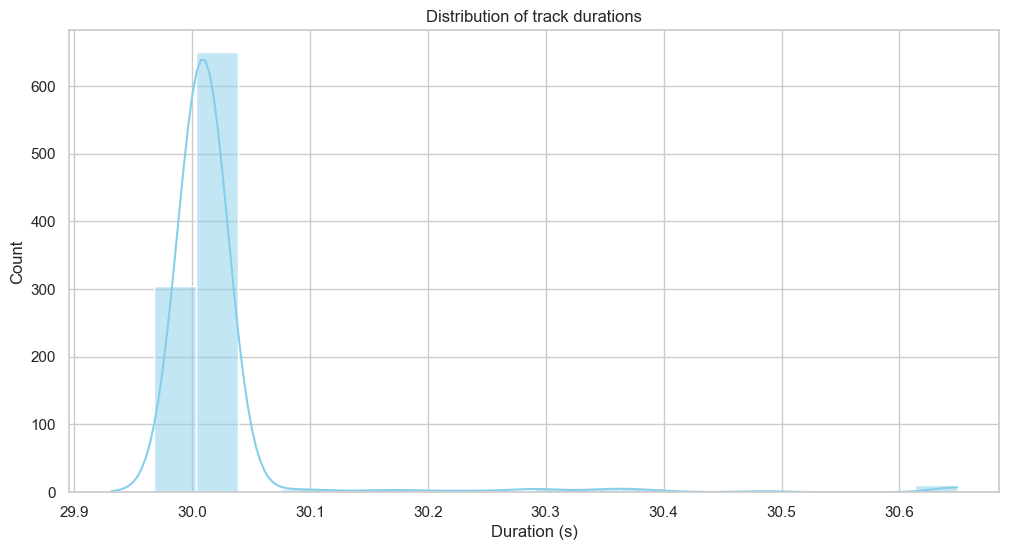

Mean duration: 30.024074648526074
Min duration: 29.931972789115648
Max duration: 30.648888888888887


In [3]:
# ===============================
# 4️⃣ Długość nagrań
# ===============================
durations = [librosa.get_duration(y=a, sr=22050) for a in df['audio']]
df['duration'] = durations

plt.figure()
sns.histplot(df['duration'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of track durations")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.show()

# Średnia i min/max długości
print("Mean duration:", np.mean(durations))
print("Min duration:", np.min(durations))
print("Max duration:", np.max(durations))


In [14]:
# ===============================
# 5️⃣ Extended Feature Extraction (MFCC, Chroma, RMS, Spectral Contrast, ZCR)
# ===============================
def extract_features_ext(audio, sr=22050):
    # MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    
    # Chroma
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    
    # RMS
    rms = librosa.feature.rms(y=audio)
    rms_mean = np.mean(rms)
    
    # Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    spec_contrast_mean = np.mean(spec_contrast, axis=1)
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    zcr_mean = np.mean(zcr)
    
    return np.concatenate([
        mfcc_mean, mfcc_std, 
        chroma_mean, chroma_std, 
        [rms_mean], 
        spec_contrast_mean, 
        [zcr_mean]
    ])

features_ext = np.array([extract_features_ext(a) for a in df['audio']])
print("Features shape:", features_ext.shape)


Features shape: (1000, 59)


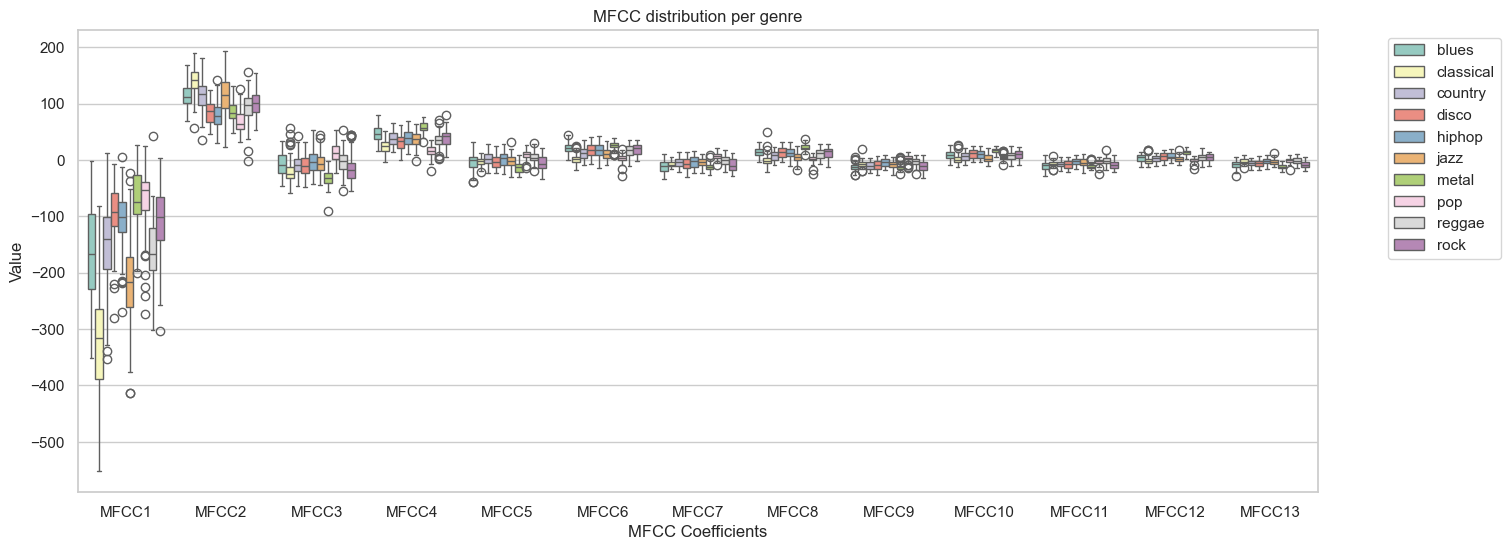

In [5]:
# ===============================
# 6️⃣ MFCC Boxplot per genre
# ===============================
mfcc_cols = [f"MFCC{i+1}" for i in range(13)]
mfcc_df = pd.DataFrame(features_ext[:, :13], columns=mfcc_cols)
mfcc_df['genre'] = df['genre']

plt.figure(figsize=(16,6))
sns.boxplot(x='variable', y='value', hue='genre',
            data=pd.melt(mfcc_df, id_vars='genre'), palette="Set3")
plt.title("MFCC distribution per genre")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


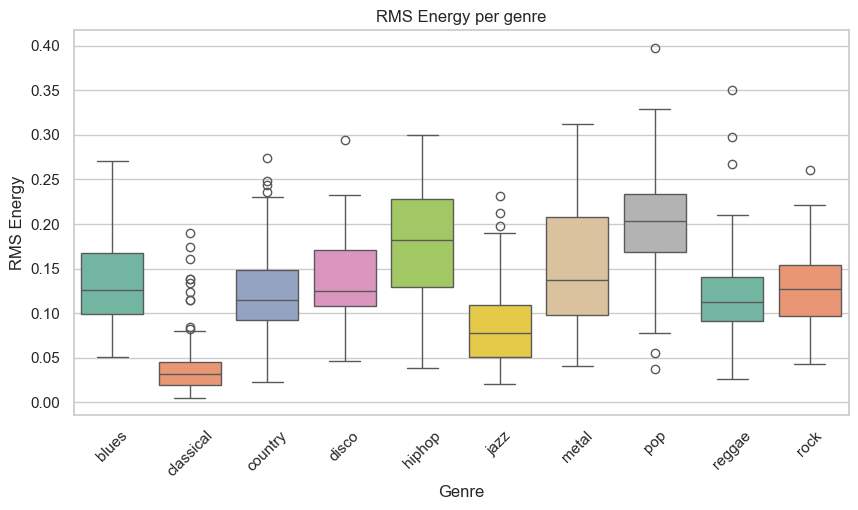

In [10]:
# ===============================
# 7️⃣ RMS Energy per genre
# ===============================
rms_df = pd.DataFrame({'rms': features[:, -1], 'genre': df['genre']})

plt.figure(figsize=(10,5))
sns.boxplot(
    x='genre',
    y='rms',
    data=rms_df,
    hue='genre',
    dodge=False,
    legend=False,
    palette='Set2'
)
plt.title("RMS Energy per genre")
plt.xlabel("Genre")
plt.ylabel("RMS Energy")
plt.xticks(rotation=45)
plt.show()



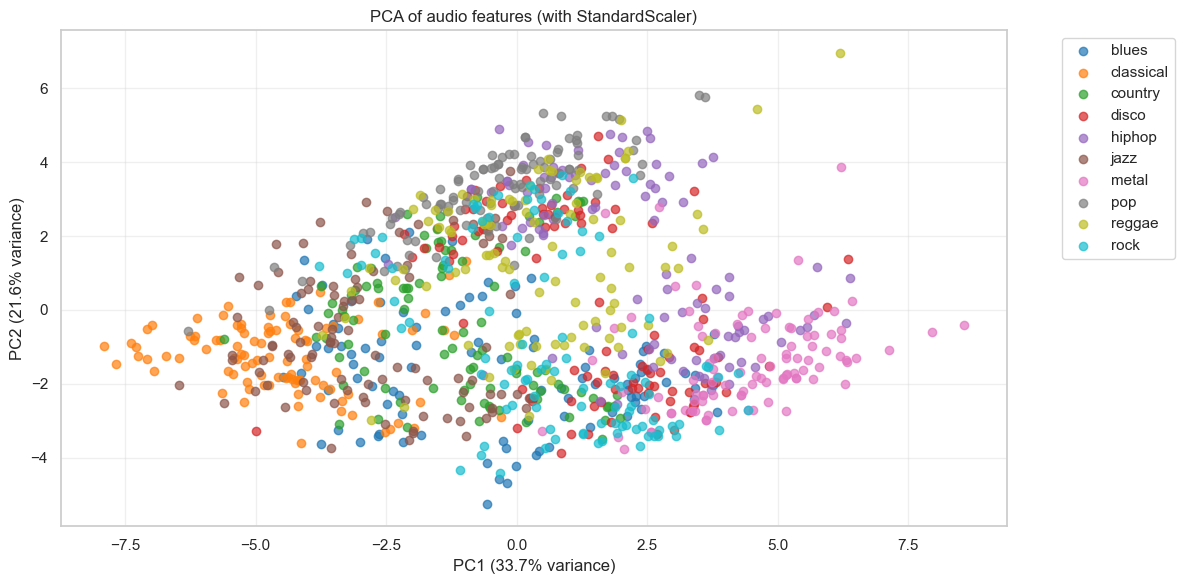

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 8️⃣ PCA (Poprawione)
# ===============================

# 1. NAJWAŻNIEJSZE: Skalowanie danych (Standaryzacja)
# Sprawiamy, że każda cecha ma średnią 0 i odchylenie standardowe 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)  # Używamy przeskalowanych danych

# 2. PCA na przeskalowanych danych
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Rysowanie wykresu
plt.figure(figsize=(12, 6))
colors = sns.color_palette("tab10", 10)

for i, genre in enumerate(class_names):
    # Wybieramy indeksy wierszy dla danego gatunku
    idx = df['genre'] == genre
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=genre, alpha=0.7, color=colors[i])

# Dodałem też informację o tym, ile wariancji tłumaczą te osie
plt.title("PCA of audio features (with StandardScaler)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3) # Dodanie siatki ułatwia czytanie
plt.tight_layout()
plt.show()

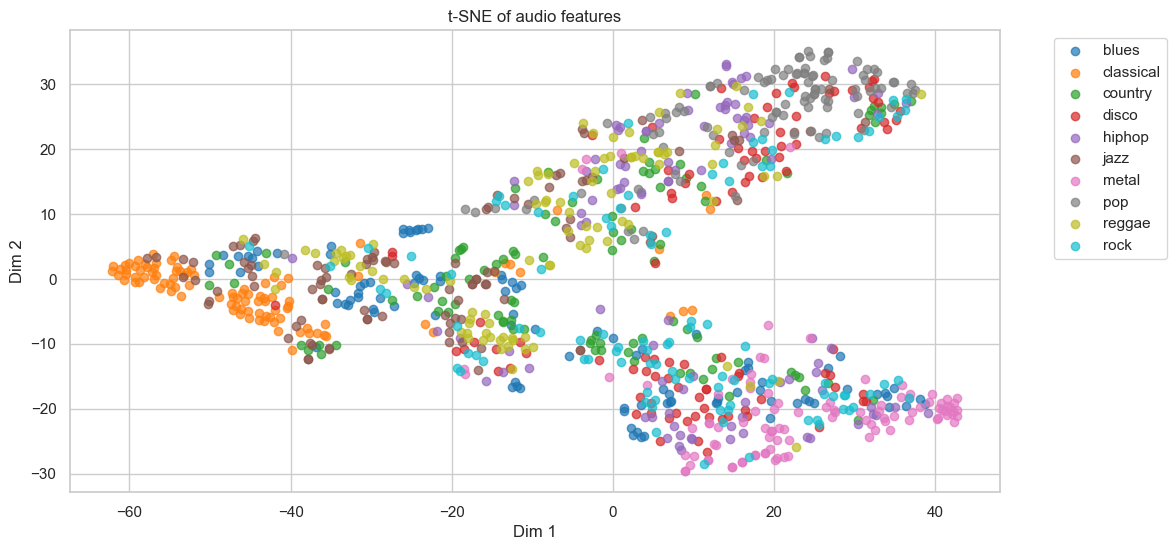

In [13]:
# ===============================
# 9️⃣ t-SNE
# ===============================
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(features)

plt.figure(figsize=(12,6))
for i, genre in enumerate(class_names):
    idx = df['genre'] == genre
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], label=genre, alpha=0.7, color=colors[i])
plt.title("t-SNE of audio features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# ===============================
# 10️⃣ EDA Summary
# ===============================
"""
Podsumowanie EDA — GTZAN

Dane: 1000 nagrań, 10 gatunków, 100 utworów na gatunek.

Długość: ~30 s, SR=22050 Hz, spójne próbki.

RMS Energy:

Classical: niska, duża zmienność

Pop / Hip-hop: wysoka, stabilna 

Metal: wysoka, umiarkowany rozrzut 

MFCC: MFCC1 → energia, MFCC2-13 → barwa; Classical wyróżnia się najniższymi MFCC1.

Redukcja wymiarów (PCA / t-SNE):

Classical i Jazz → wyraźnie odseparowane 

Rock / Country / Disco → częściowe nakładanie 

Metal / Pop → zwarte, drobne nakładki

Wnioski:

Najłatwiejszy do klasyfikacji gatunek: Classical 

Najtrudniejsze do rozróżnienia: Rock vs Country vs Blues 

Zadanie umiarkowanie trudne, możliwa dokładność 60–80% na prostych modelach
"""
